# 0. Now we have chose FoodVision from PyTorvh torchvision to work with

We need to:
1. Prepare our data from torch vision
2. Build a model( we will use pre-build model to make comparison)
    * 1. Choose an optimizer and loss function
    * 2. Design a training and testing loop
3. Fit the model to the data and make a prediction
4. Evaluate the model
5. Improve through experiment
6. Save model

## 2. Build a model

Build a CNN Model
5 layers

In [12]:
import torch as T
import torch.nn as nn
# a function to create conv_2d
def create_conv2d(hidden_units):
    layer = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
    )
    return layer

In [117]:
## Create a model by subclassing nn.module
import torch as T
import torch.nn as nn


class VGGV0(nn.Module):
    def __init__(self, input_size,
                  hidden_units,
                    output_size):
        super().__init__()
        self.Conv2d_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.Conv2d_layer_2 = create_conv2d(hidden_units=hidden_units)
        self.Conv2d_layer_3 = create_conv2d(hidden_units=hidden_units)
        self.Conv2d_layer_4 = create_conv2d(hidden_units=hidden_units)
        self.Conv2d_layer_5 = create_conv2d(hidden_units=hidden_units)
        self.Classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*15,
                      out_features=output_size)
        )

    def forward(self, x):
        #x = self.Conv2d_layer_1(x)
        #print(x.shape)
        #x = self.Conv2d_layer_2(x)
        #print(x.shape)
        #x = self.Conv2d_layer_3(x)
        #print(x.shape)
        #x = self.Conv2d_layer_4(x)
        #print(x.shape)
        #x = self.Conv2d_layer_5(x)
        #print(x.shape)
        #x = self.Classifier(x)
        #print(x.shape)
        return self.Classifier(self.Conv2d_layer_5(self.Conv2d_layer_4(self.Conv2d_layer_3(self.Conv2d_layer_2(self.Conv2d_layer_1(x)))))) 

### Create a dummy model for testing

In [118]:
# Setup device mode
device = "cuda" if T.cuda.is_available() else "cpu"
device

'cuda'

In [119]:
modelV0 = VGGV0(input_size=3,
                hidden_units=64,
                output_size = 1000).to(device)
modelV0

VGGV0(
  (Conv2d_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv2d_layer_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv2d_layer_3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv2d_layer_4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

### 2.1 Setup optimizer and loss function

In [120]:
# Create loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = T.optim.Adam(params=modelV0.parameters(),
                         lr=0.01)

(-0.5, 113.5, 180.5, -0.5)

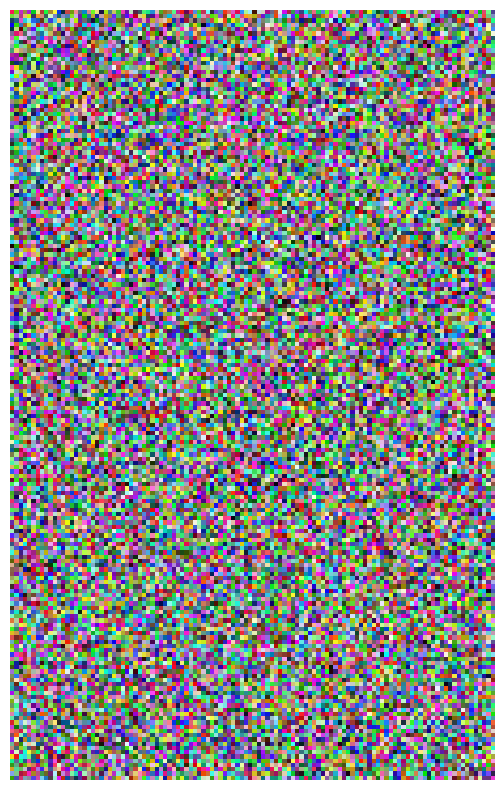

In [121]:
## Create a dummy image to test model working as intended
import random
import numpy as np
random.seed(42)

# Define a dummy image shape
dummy_image_shape = (random.randint(100, 224), random.randint(100, 224), 3)  # [Height, Width, Channels]

# Generate random pixel values for the dummy image (0-255)
dummy_image = np.random.randint(0, 255, dummy_image_shape, dtype=np.uint8)
# [Color channels, Width, Height]

# try printing image
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.imshow(dummy_image)
plt.axis(False)

In [123]:
from torchvision.transforms import ToTensor
#permuted_image = np.transpose(dummy_image,(1,2,0))
#transform image into tensor
totensor = ToTensor() # MUST DEFINE FIRST cant use directly
image_tensor = totensor(dummy_image)
image_tensor.shape
y=modelV0(image_tensor.unsqueeze(dim=0).to(device))

Model VGG build success fully

### 2.2 Build a training loop and testing


In [138]:
# training loop

from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=1000).to(device)
def train_step(model:nn.Module,
               train_dataloader:T.utils.data.DataLoader,
               loss_fn:nn.Module,
               optimizer:T.optim.Optimizer,
               device:T.device)->tuple[float,float]:
    
    ### TRAIN ###
    model.train()
    loss_value, acc_value = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        # Predict y from X 
        X, y=X.to(device), y.to(device)
        pred_logit = model(X)
        loss = loss_fn(pred_logit,y)
        # Calculate the loss and acc
        loss_value+=loss.item()
        acc = acc_fn(T.softmax(pred_logit, dim=1).argmax(dim=1), y).item()
        acc_value += acc
        #
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #
    loss_value /= len(train_dataloader)
    acc_value /= len(train_dataloader)
    return loss_value, acc_value

In [140]:
# testing loop
def test_step(model:nn.Module,
              test_dataloader:T.utils.data.DataLoader,
              loss_fn:nn.Module,
              device:T.device) ->tuple[float,float] :
    ### Test ###
    model.eval()
    loss_val = 0
    acc_val = 0
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.to(device)
        # make test prediction model
        test_pred_logit = model(X)
        #  calculate the loss and acc
        loss = loss_fn(test_pred_logit,y)
        loss_val += loss.item()
        acc = acc_fn(T.softmax(test_pred_logit, dim=1).argmax(dim=1), y).item()
        acc_val += acc
    loss_val /= len(test_dataloader)
    acc_val /= len(test_dataloader)
    return loss_val, acc_val

### UNIT TESTING ###

In [126]:
## unit testing

# Create dummy dataloader
from torch.utils.data import DataLoader, Dataset
class DummyDataset(Dataset):
    def __init__(self,image,num_sample):
        self.image = image
        self.label = 0
        self.num_sample = num_sample
    
    def __len__(self):
        return self.num_sample
    
    def __getitem__(self,idx):
        return self.image, self.label
   
dummy_datasets = DummyDataset(image_tensor,32)
dummy_dataloader = DataLoader(dummy_datasets,
                              batch_size=8,
                              shuffle=True)
for batch_idx, (images, labels) in enumerate(dummy_dataloader):
    print(images.shape)

torch.Size([8, 3, 181, 114])
torch.Size([8, 3, 181, 114])
torch.Size([8, 3, 181, 114])
torch.Size([8, 3, 181, 114])


In [139]:
# TESTING FOR train_step()
train_loss, train_acc = train_step(model=modelV0,
                                   train_dataloader=dummy_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   device=device)
train_loss, train_acc

(6.897270679473877, 0.0)

In [141]:
# UNIT TESTING FOR train_step()
test_loss, test_acc = test_step(model=modelV0,
                                   test_dataloader=dummy_dataloader,
                                   loss_fn=loss_fn,
                                   device=device)
test_loss, test_acc

(6.897270679473877, 0.0)

## Training and Testing Loop

In [143]:
from tqdm.auto import tqdm
def train(model:nn.Module,
          train_dataloader:T.utils.data.DataLoader,
          test_dataloader:T.utils.data.DataLoader,
          loss_fn:nn.Module,
          optimizer:T.optim.Optimizer,
          epochs:int,
          device:T.device):
    for epoch in tqdm(range(epochs)):
        # Create empty results dictionary
        results = {"train_loss": [],
                "train_acc": [],
                "test_loss": [],
                "test_acc": []
        }
        model.to(device)
        train_loss, train_acc = train_step(model=model,
                                        train_dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device)
        test_loss, test_acc = test_step(model=model,
                                        test_dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results
    

In [144]:
# Testing train()
results = train(model=modelV0,
                train_dataloader=dummy_dataloader,
                test_dataloader=dummy_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=3,
                device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.8973 | train_acc: 0.0000 | test_loss: 6.8973 | test_acc: 0.0000
Epoch: 2 | train_loss: 6.8973 | train_acc: 0.0000 | test_loss: 6.8973 | test_acc: 0.0000
Epoch: 3 | train_loss: 6.8973 | train_acc: 0.0000 | test_loss: 6.8973 | test_acc: 0.0000


In [145]:
results

{'train_loss': [6.897270679473877],
 'train_acc': [0.0],
 'test_loss': [6.897270679473877],
 'test_acc': [0.0]}